# Assets and Nighttime Lights

Nighttime lights are evidence of higher level of wealth and assets. Using the Nigerian [Demographic and Health survey](https://www.dhsprogram.com/data/dataset/Nigeria_Standard-DHS_2013.cfm?flag=0) as an example, we can explore this relationship.

The data itself requires registering to download, so if run locally, will use randomly generated synthetic data.

This impetus for this example is a [paper](http://science.sciencemag.org/content/353/6301/790) by Neal Jean _et al_

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import os
from pprint import pprint
from rasterio.mask import mask
%matplotlib inline
DATA_PATH = '/data/PyDataSpatialAnalysis/data'

Load all of the data files

In [2]:
nightlights = rasterio.open(DATA_PATH + '/F182013.v4c_web.stable_lights.avg_vis.tif')
nigeria_gdf = gpd.read_file(os.path.join(DATA_PATH, 'formatted_dhs/'))
nigeria_gdf.head()

,cluster,assets,geometry
0,1.0,-106269,POINT (8.097115000000001 6.90227)
1,1.0,-89171,POINT (8.097115000000001 6.90227)
2,1.0,-101669,POINT (8.097115000000001 6.90227)
3,1.0,-105983,POINT (8.097115000000001 6.90227)
4,1.0,-89785,POINT (8.097115000000001 6.90227)


`nigeria_gdf` is a GeoDataFrame. This is like a Pandas DataFrame but has an additional functionality to handle the geometry for each row. This is mostly handled by special 'geometry' column. The `crs` property contains the coordinate reference system of the geometries.

In [3]:
print(nigeria_gdf.crs)

{'init': 'epsg:4326'}


4326 is the EPSG code for lat/lon using the WGS84 datum. This is the coordinate reference system used by GPS and is very common

In this case, the geometries are all points. The data are clustered for privacy reason. Each survey is put into a cluster of with ~5km of random noise. 

Since `geopandas` objects just extend `pandas`, can still use all the pandas functionality to explore the data. For example, can quickly plot a histogram of asset scores

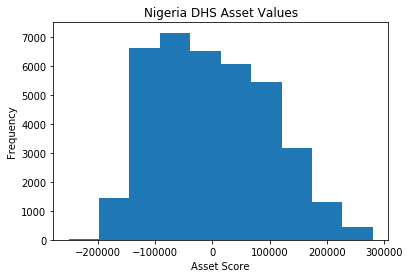

In [4]:
ax = nigeria_gdf.assets.plot(kind='hist')
_ = ax.set_title('Nigeria DHS Asset Values')
_ = ax.set_xlabel('Asset Score')

Let's just look at the location and aggregate values of each cluster. Annoyingly, the `groupby` operation results in a `DataFrame`, not a `GeoDataFrame`, so we have to jump through some hoops to get it back (and with the right coordinate reference). `set_geometry` specifies which column holds the geometric data.

In [5]:
clusters_ = nigeria_gdf.groupby('cluster').agg({'assets': 'median', 'geometry': 'first'})
clusters = gpd.GeoDataFrame(clusters_).set_geometry('geometry')
clusters.crs = nigeria_gdf.crs

Now we can do some simple plotting to see where are data are. To get the outline of Nigeria, we can use the dataset that comes as part of GeoPandas. As always, we need to verify that everything is in the same coordinates before combining data. In this case, the world data are also in EPSG 4326, so we are good to go!

In [56]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(world.crs)
nigeria = world[world.iso_a3 == "NGA"]

{'init': 'epsg:4326'}


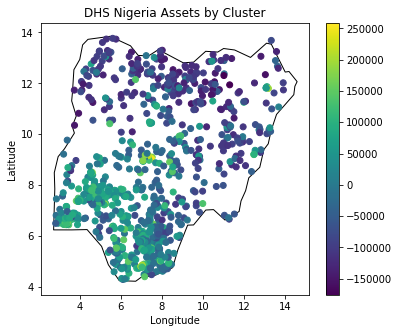

In [58]:
fig, ax = plt.subplots(figsize=(6,5))
world[world.iso_a3 == 'NGA'].plot(color='white', edgecolor='black', ax=ax)
clusters.plot(ax=ax, column='assets', legend=True)
_ = ax.set_xlabel('Longitude')
_ = ax.set_ylabel('Latitude')
_ = ax.set_title('DHS Nigeria Assets by Cluster')

## Raster Data with `rasterio`

In [8]:
import rasterio
from rasterio.mask import mask

In [9]:
nightlights = rasterio.open(DATA_PATH + '/F182013.v4c_web.stable_lights.avg_vis.tif')

Raster data is essentially just an image file with associated meta data. Additionally, the image channels are not necessarily limited to RGB values. For example, satellites often collect many more bands of lights. The [MODIS](https://en.wikipedia.org/wiki/Moderate_Resolution_Imaging_Spectroradiometer) satellite images contain 36 bands.

Rasterio `meta` property show the meta data related to image coordinates and transformations. The number of bands are available in the `indexes` method. In our case, only one band is available.

In [21]:
pprint(nightlights.meta)
pprint(nightlights.indexes)

{'count': 1,
 'crs': CRS({'init': 'epsg:4326'}),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 16801,
 'nodata': None,
 'transform': Affine(0.0083333333, 0.0, -180.00416666665,
       0.0, -0.0083333333, 75.00416666665),
 'width': 43201}
(1,)


As with the vector data, we want to know what coordinate reference system is used for the data

In [23]:
print(nightlights.crs)

CRS({'init': 'epsg:4326'})


Again, we see EPSG 4326. Since this is raster data, this means (x,y) values are just (lon, lat) pairs. This projection is called Plate Carrée.

We can see what the bounds of the data are by using the `bounds` property. The units of the bounds depend on the projetion. In this case, the units are degrees lon/lat. The`height` and `width` properties have the pixel height and width

In [25]:
print(nightlights.bounds)
print('Image size: ({}, {})'.format(nightlights.width, nightlights.height))

BoundingBox(left=-180.00416666665, bottom=-65.00416610665, right=180.00416522665, top=75.00416666665)
Image size: (43201, 16801)


To go from pixel coordinates to lon/lat, use the `transformation`, which returns an `Affine` object. To go from lon/lat to pixel indices, `~` will invert the affine transformation.

In [12]:
upper_left_pixel = nightlights.transform * (0,0)
pixel_for_zero_zero = (~nightlights.transform * (0,0))
print("Affine Transformation: \n{}".format(nightlights.transform))
print("Lon/lat of upper left pixel: {}".format(upper_left_pixel))
print("Pixel location for (0, 0) lon/lat: {}".format(pixel_for_zero_zero))

Affine Transformation: 
| 0.01, 0.00,-180.00|
| 0.00,-0.01, 75.00|
| 0.00, 0.00, 1.00|
Lon/lat of upper left pixel: (-180.00416666665, 75.00416666665)
Pixel location for (0, 0) lon/lat: (21600.5000864, 9000.500036)


Since the image is so big, don't want to show the entire thing. We can use the `mask` module to mask out just the pixels that are inside the polygon that defines the boarders of Nigeria. 

That polygon has to be in the same coordinates as the rasterio object. The Shapely objects do not know anything about the meaning of their coordinates. They are just two dimensional objects. As a result, there is no checks to make sure the coordinate systems match. You have to do that yourself. Since everything is in EPSG 4326, we don't have to make a transformation.

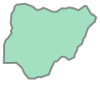

In [73]:
nigeria_polygon = nigeria.geometry.values[0]
nigeria_polygon

In [55]:
world.crs

{'init': 'epsg:4326'}

In [68]:
nigeria_lights, out_transform = mask(nightlights, 
                                     [nigeria_polygon], 
                                     crop=True)

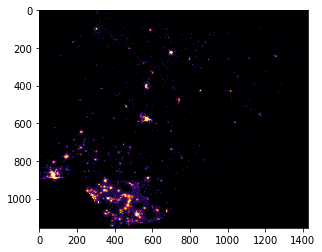

In [69]:
plt.imshow(nigeria_lights[0], cmap='inferno')

A bit hard to see the boarders of Nigeria as both so much of the country has so little nighttime light activity. A simple function to show the nighttime light of any country by the three letter country code:

In [53]:
def nighttlights_by_country(country):
    try:
        country_polygon = world.loc[world.iso_a3 == country, 'geometry'].values[0]
    except IndexError:
        print('Invalid Country Code')
        return None
    night_lights, _ = mask(nightlights, 
                           [country_polygon], 
                           crop=True)
    ax = plt.imshow(night_lights[0], cmap='inferno')
    return ax

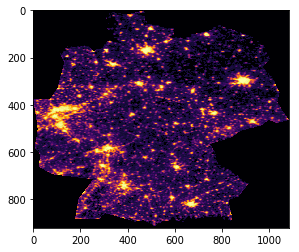

In [54]:
nighttlights_by_country('DEU')

## Nighttime Light for Each Cluster

To find the nighttime light intensity for each cluster in the dataset, we can do the same process of masking the raster data at the location of each cluster and taking the average.  However, when we naively the same process for a sample point, rasterio throws a `ValueError`. This is because a Point geometry type is infinitesimal in space, so the mask has no intersection.

In [67]:
sample_pt = clusters.geometry[1]
# Will throw a ValueError
try:
    sample_mask, _ = mask(nightlights, [sample_pt], crop=True)
except ValueError:
    print('Told you so')

Told you so


To handle this, we need convert the Points into Polygons. An easy way to do this is to use the `buffer` method on Shapely objects. `buffer` on any object returns a Polygon that contains the area within the buffer distance of the initial object. As Shapely objects do not do not know anything about their projection, the buffer distance is expressed in whatever units the projection uses. For EPSG 4326, this is degrees lon/lat, so `buffer(0.01)` would buffer the point by 0.01 degrees in both longitude and latitude.

Any distances expressed in degrees lon/lat are generally not a good idea. This is because a degree of latitude is (nearly) constant in meters, but a degree of longitude varies from ___ at the equator to 0 m at the poles. Buffering by a constant number of degrees would lead to different distances North-South than East-West.

A good way to handle this problem is to use a different projection in which the x-y values can be expressed in meters, not degrees. The series of transverse mercator projections the comprise the UTM system are a good way to do this. These are __ transverse mercator projections; the projection to use is based on the longitude of interest. In our case, we are in zone 32 N (N since we are interested in the northern hemisphere.) I find which projection by typing it into Google. To find the string version, I refer to the EPSG website and get `"+proj=utm +zone=32 +ellps=GRS80 +units=m +no_defs"`. The EPSG website also clarifies that the units of the projection are in fact in meters.

Once projeted in UTM 32N, each point can be buffered in meters. Since there is 5km of random noise, we'll buffer by 5000 meters. In order to compare with the nighlights raster data, however, we need to transform back into EPSG 4326.

To recap, the process is:

1. Transform each Point from EPSG 4326 to UTM 32 N
2. Buffer each Point by 5000 m to create a Polygon
3. Transform each Polygon from UTM 32 N back to EPSG 4326
4. Calulate interestion of nightlights

In [68]:
def geom_to_mean_light(geom):
    try:
        out_image, out_transform = mask(nightlights, [geom], crop=True)
        res = out_image.mean()
    except ValueError:
        print('Uh-oh.... loooks like something is wrong....')
        res = -1
    return res

In [127]:
new_crs = "+proj=utm +zone=32 +ellps=GRS80 +units=m +no_defs"
old_crs = "+init=epsg:4326"
new_projection = clusters.geometry.to_crs(new_crs)
buffered = new_projection.buffer(5000)
original_projection = buffered.to_crs(old_crs)
mean_night_lights = original_projection.map(geom_to_mean_light)
clusters['mean_night_light'] = mean_night_lights


### Why all the trouble with projections?

To demonstrate the why this is needed, let's look at what happens if we perform steps 1-3 on a point in Nigeria and a point 40 degrees further North, which is just a bit outside of Frankfurt. By going straight North, the same projection has very little distorion for both points.

In [80]:
import shapely.geometry

In [117]:
german_pt = shapely.geometry.Point(8,49)
nigeria_pt = shapely.geometry.Point(8,9)
geo_series = gpd.GeoSeries([german_pt, nigeria_pt], index=['Germany', 'Nigeria'])
geo_series.crs=clusters.crs

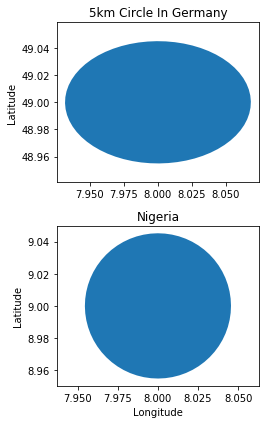

In [143]:
new_crs = "+proj=utm +zone=32 +ellps=GRS80 +units=m +no_defs"
old_crs = "+init=epsg:4326"
fig, ax = plt.subplots(2, figsize=(4,6))
ax[0].axis('equal')
ax[1].axis('equal')
geo_series.to_crs(new_crs).buffer(5000).to_crs(old_crs)[['Germany']].plot(ax=ax[0])
geo_series.to_crs(new_crs).buffer(5000).to_crs(old_crs)[['Nigeria']].plot(ax=ax[1])
ax[0].set_title('5km Circle In Germany')
ax[1].set_title('Nigeria')
ax[1].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[1].set_ylabel('Latitude')
fig.tight_layout()

Both of these polygons are actually circles with 5km radius on the ground. But when plotted as lon/lat, which is the Plate Carrée projection, the circle further North looks distorted. This is a consequence of the projection as a degree of latitude is significantly less distance in Germany than it is in Nigeria.

### Relationship between Nighttime Light and Assets

In [120]:
import seaborn as sns

In [121]:
clusters.head()

,assets,geometry,mean_nightlight,mean_night_light
cluster,,,,
1.0,-93782.0,POINT (8.097115000000001 6.90227),0.0,0.0
2.0,-51549.0,POINT (7.876807 7.854454),0.0,0.0
3.0,-62769.0,POINT (7.940457 7.781454),0.0,0.0
4.0,-26352.5,POINT (9.197081000000001 7.176902),0.0,0.0
5.0,-81383.5,POINT (9.164210000000001 7.148612),0.0,0.0


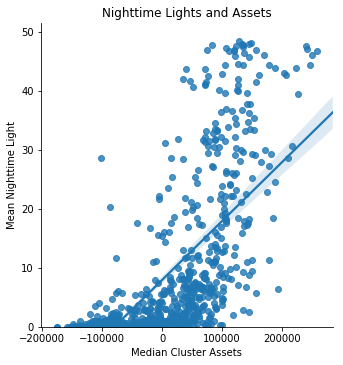

In [156]:
asset_plot = sns.lmplot(y='mean_night_light', x='assets', data=clusters)
ax = asset_plot.axes[0,0]
ax.set_ylim(-0,)
ax.set_ylabel('Mean Nighttime Light')
ax.set_title('Nighttime Lights and Assets')
ax.set_xlabel('Median Cluster Assets')
asset_plot.savefig('/Users/dillon/Desktop/assets.png')